In [103]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [104]:
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'cmu serif' #"Helvetica"

In [105]:
# results_path = '../runs_06/gradual_overlap/softmax'
# results_path = '../runs_08/cifar20_100_new/softmax'
# results_path = '../runs_09/cifar10/softmax'
# results_path = '../runs_09/cifar20_100/softmax'
results_path = '../runs_10/cifar20_100/softmax'

In [114]:
l2d_type_lst = ['single', 'pop', 'pop_attn', 'pop_attn_sa']
p_out_lst = [0.1,0.2,0.4,0.6,0.8,0.95, 1.0]
seed_lst = [1071,3918,4420,5251,6637]
metrics_lst = ['cov', 'sys_acc', 'exp_acc', 'clf_acc', 'exp_acc_alone', 'clf_acc_alone', 'val_loss']

In [115]:
budget_lst = [0.01,0.05,0.1,0.2,1.0] # TODO: if budget=1.0 then just read "eval.log"

In [116]:
results = {}
for l2d_type in l2d_type_lst:
    results[l2d_type] = {}
    
    for budget in budget_lst:
        results[l2d_type][budget] = {}
    
        metrics_all = {metric:[[] for _ in range(len(p_out_lst))] for metric in metrics_lst}

        for ii,p_out in enumerate(p_out_lst):
            for seed in seed_lst:
                fn = f'eval{budget}.log'
                # if budget == 1.0: # TODO
                #     fn = 'eval.log'
                
                fn_path = os.path.join(results_path, f'l2d_{l2d_type}', f'p{p_out}_seed{seed}', fn)

                try:
                    line = open(fn_path).readline().rstrip()
                except FileNotFoundError:
                    print(fn_path)
                else:
                    line_split_grp = [line.split()[i:i+2] for i in range(0, len(line.split()),2)]
                    for [metric,val] in line_split_grp:
                        if metric=='cov':
                            cov = val.split('/')
                            metrics_all[metric][ii].append(int(cov[0])/int(cov[1]))
                        else:
                            metrics_all[metric][ii].append(float(val))

        for metric, vals in metrics_all.items():
            results[l2d_type][budget][metric] = np.vstack(vals)

In [117]:
c_red = mpl.colormaps['Set1'](0)
c_blue = mpl.colormaps['Set1'](1)

In [118]:
metrics_to_text = {
    'cov':'Coverage',
    'sys_acc': 'System accuracy',
    'exp_acc': 'Expert accuracy\non deferred examples',
    'clf_acc': 'Classifier accuracy\n on non-deferred examples',
    'clf_acc_alone': 'Classifier accuracy\n on all examples',
    'val_loss': 'Test loss'
}

In [121]:
l2d_type_to_text = {
    'single': 'Single-expert',
    'pop': 'Population',
    # 'pop_attn': 'Population w/ attention'
    'pop_attn': 'Population + CA',
    'pop_attn_sa': 'Population + CA + SA'
}

Text(0, 0.5, 'System accuracy')

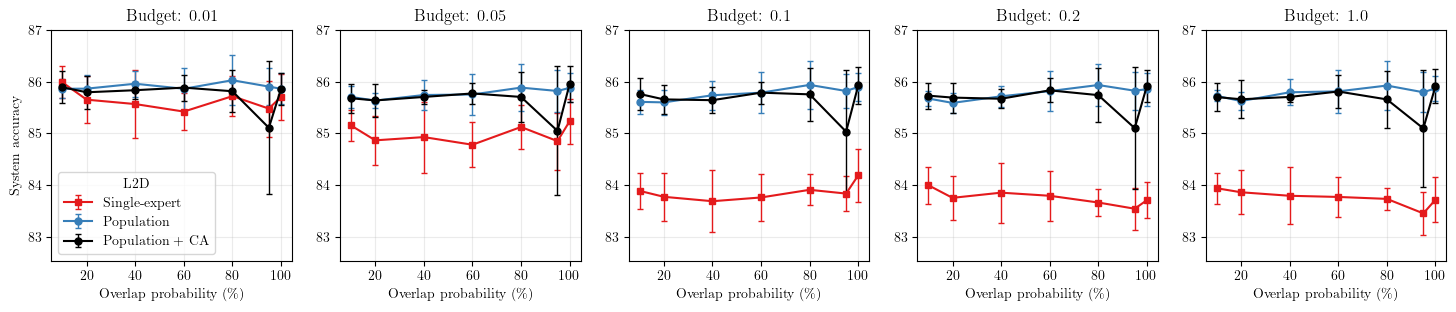

In [124]:
metric_show = 'sys_acc' #'exp_acc' #'sys_acc'
budgets_show = [0.01,0.05,0.1,0.2,1.0]

fig,axs = plt.subplots(1,len(budgets_show),figsize=(18,3))

l2d_show = ['single', 'pop', 'pop_attn'] # 'pop_attn_sa'
p_out_show = [0.1,0.2,0.4,0.6,0.8,0.95,1.0]
res_filter = [np.where(np.array(p_out_lst)==p)[0].item() for p in p_out_show]

metric_to_col = {'single':c_red,'pop':c_blue,'pop_attn':'k', 'pop_attn_sa':'g'}
metric_to_marker = {'single':'s-','pop':'o-','pop_attn':'o-', 'pop_attn_sa':'o-'}
errbar_args={'capsize':2, 'markersize':5, 'elinewidth':1., 'capthick':1., 'lw':1.5} # 'fmt':'o-'

yvals_all = []
for ax,budget in zip(axs,budgets_show):
    for l2d_type in l2d_show:
        metric_mean = np.mean(results[l2d_type][budget][metric_show][res_filter], axis=1)
        metric_std = np.std(results[l2d_type][budget][metric_show][res_filter], axis=1)
        overlap_prob = np.array(p_out_show)*100
        ax.errorbar(overlap_prob, metric_mean, yerr=metric_std, label=l2d_type_to_text[l2d_type], c=metric_to_col[l2d_type], fmt=metric_to_marker[l2d_type], **errbar_args)
        ax.set_xlabel('Overlap probability (\%)')
        yvals_all += [metric_mean-metric_std, metric_mean+metric_std]
    ax.set_title(f'Budget: {budget}')
    ax.grid(True, alpha=0.25)
    
yvals_all = np.array(yvals_all)
buffer=0.5
for ax in axs:
    ax.set_ylim(yvals_all.min()-buffer, yvals_all.max()+buffer)
    
axs[0].legend(title='L2D')
axs[0].set_ylabel(metrics_to_text[metric_show])
# fig.savefig('cifar20_warmstart_expacc.png', dpi=600, facecolor='white', bbox_inches="tight")